In [1]:
from Utils_Bashivan import *

In [2]:
import numpy as np

3D sensors locations on the scalp, to be converted to 2D later.

In [3]:
locs = np.load('Electroloc/Neuro_loc_DEAP.npy')

In [4]:
locs.shape

(32, 3)

In [5]:
locs[:5]

array([[-28.23010227, 102.26294022,  31.73459731],
       [-32.32332412,  97.52191223,  59.21113179],
       [-48.18205131,  76.34876907,  80.94883837],
       [-67.35513444,  62.32957061,  30.46685071],
       [-74.02481482,  42.12832367,  66.46981722]])

In [6]:
deap_path = '../../datasets/DEAP/merged/'
save_path = '../../datasets/DEAP/image_generation'

In [7]:
X = np.load(deap_path + 'deap_data.npy')
X.shape

(1280, 40, 8064)

In [8]:
y = np.load(deap_path + 'deap_full_labels.npy')
y.shape

(1280, 3)

Use only EEG channels

In [95]:
X_eeg = X[:, :32, :]

Conversion of 3D to 2D coordinates (Azimuthal Equidistant Projection)

In [9]:
n_gridpoints = 32

In [10]:
locs_2d = np.empty((locs.shape[0], 2))
locs_2d.shape

(32, 2)

In [11]:
for i, sensor_location in enumerate(locs):
    locs_2d[i] = azim_proj(sensor_location)

In [12]:
locs_2d[:5]

array([[-0.34064478,  1.23397841],
       [-0.3297067 ,  0.99475002],
       [-0.44821694,  0.71023983],
       [-0.91763312,  0.84916582],
       [-0.78925268,  0.44917225]])

For the features parameter the PSD (Power Spectral Density) of each channel must be computed. For each channel there will be N frequency bands, so the features shape will be (n_samples, n_channels * N)

https://mne.tools/stable/generated/mne.time_frequency.psd_multitaper.html

https://mne.tools/stable/generated/mne.time_frequency.psd_array_multitaper.html

https://mne.tools/stable/generated/mne.filter.resample.html

In [13]:
import mne

In [14]:
# def compute_psd(epoch, fmin=-1., fmax=60.):
#     psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=10, verbose=50)
#     return resample(psds, num=1500, axis=2)[0, :]

Compute PSD for participant 2, as an example

Final features shape should be (n_samples, n_features), where n_samples = 1280 (32 subjs * 40 trials) and n_features = 40 * X (40 channels and X frequency bands)

For each frequency band the paper states to compute the square sum of the frequencies involved, to get a single value (TO CHECK)

In [179]:
psds, freqs = mne.time_frequency.psd_array_multitaper(X[1], sfreq=128, fmin=-1., fmax=60., verbose=50)

In [180]:
# psds_resample = mne.filter.resample(psds, axis=1)

Here psd_array_multitaper computer the psds for every channel and assembled it together, later only one channel at a time will be calculated with the Welch method

In [181]:
print(psds.shape)
print(freqs.shape)

(40, 3781)
(3781,)


In [18]:
#print(*freqs, sep='\t')

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

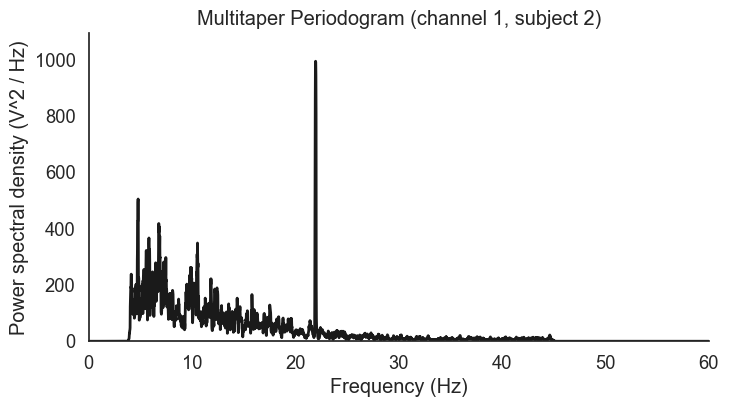

In [184]:
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psds[0], color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psds[0].max() * 1.1])
plt.title("Multitaper Periodogram (channel 1, subject 2)")
plt.xlim([0, freqs.max()])
sns.despine()

Trying Welch method for PSD

https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html

https://mne.tools/stable/generated/mne.time_frequency.psd_welch.html

In [172]:
psds_w, freqs_w = mne.time_frequency.psd_array_welch(X[1, 0], sfreq=128, fmin=-1., fmax=60., 
                                                          n_overlap=0, n_per_seg=4*128, average='mean', verbose=50)

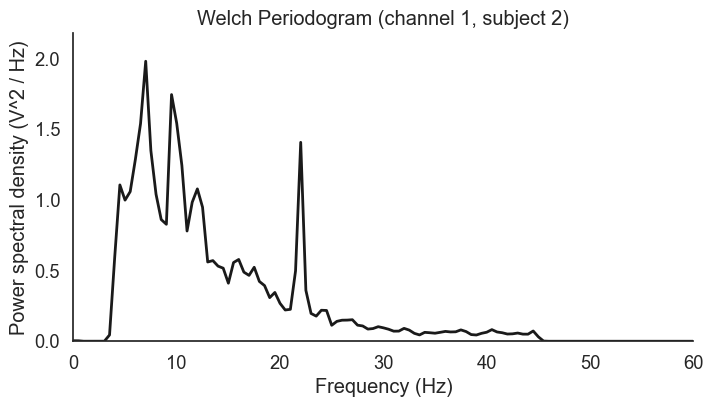

In [173]:
# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs_w, psds_w, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psds_w.max() * 1.1])
plt.title("Welch Periodogram (channel 1, subject 2)")
plt.xlim([0, freqs_w.max()])
sns.despine()

In [81]:
bands = [4, 8, 10, 12, 30, 60] # 5 frequency bands: theta, slow alpha, alpha, beta, gamma (DEAP paper, Saliency too?)

In [87]:
bands_bashivan = [4, 7, 13, 30] # 3 frequency bands: theta, alpha, beta

In [83]:
freqs_w.shape

(121,)

In [89]:
freqs_w

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ])

In [86]:
psds_w[0].shape

(121,)

In [90]:
def frequency_binning_reduction(psd, freqs, bands, reduction='mean'):
    reduced_frequencies = np.empty(len(bands) - 1)
    
    for i in range(len(bands) - 1):
        low_freq = bands[i]
        high_freq = bands[i+1]
        freq_points_counter = 0
        freq_band_sum = 0
        for j, freq in enumerate(freqs):
            if freq >= low_freq and freq < high_freq:
                freq_points_counter += 1
                freq_band_sum += psd[j]
                
        reduced_frequencies[i] = freq_band_sum / freq_points_counter
        
    
    return reduced_frequencies

In [93]:
test_reduced_psd = frequency_binning_reduction(psds_w[0], freqs_w, bands)
test_reduced_psd

array([1.24023777, 1.11937719, 1.13828569, 0.3808671 , 0.03295477])

In [109]:
test_reduced_psd.shape

(5,)

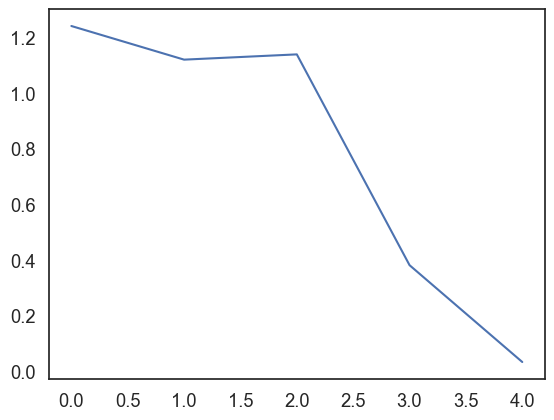

In [94]:
plt.plot(test_reduced_psd)
plt.show()

In [96]:
X_eeg.shape

(1280, 32, 8064)

In [100]:
def generate_participants_array(): # using 0-31 range as the Sal_Model.py code
    participants = np.empty((1280,))
    participant_id = 0
    
    for i in range(1280):
        if i % 40 == 0:
            participant_id += 1
        participants[i] = participant_id
    
    return participants

In [108]:
participants = generate_participants_array()
participants[:80]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

## EEG Feature Generation

In [187]:
sampling_freq = 128
deap_bands = [4, 8, 10, 12, 30, 60]
n_samples = X_eeg.shape[0] # number of participants (32) * trials (40)
n_channels = X_eeg.shape[1] # 32
n_features = n_channels * (len(deap_bands) - 1) # 32 * 5 = 160

features = np.empty((n_samples, n_features)) # shape (1280, 160)

for i, subject_data in enumerate(X_eeg):
    reduced_psds = []
    psds, freqs = mne.time_frequency.psd_array_welch(subject_data, sfreq=sampling_freq, fmin=-1., fmax=60., 
                                                     n_overlap=0, n_per_seg=4*sampling_freq, average='mean', verbose=50) 
    for j, psd_channel in enumerate(psds):        
        reduced_psd = frequency_binning_reduction(psd_channel, freqs, deap_bands)
        reduced_psds.append(reduced_psd)

    features[i] = np.stack(reduced_psds, axis=1).flatten()

In [188]:
features.shape

(1280, 160)

In [191]:
save_path

'../../datasets/DEAP/image_generation'

In [193]:
np.save(save_path + '/participants.npy', participants)

In [196]:
np.save(save_path + '/features.npy', features)

In [195]:
# images_timewin = 
# np.array([gen_images(np.array(locs_2d),
# feats[:, i * 192:(i + 1) * 192],
# 32,
# normalize=True) for i in range(int(feats.shape[1] / 192))])

## EEG Generate Images

```python 
def image_generation(feature_matrix, electrodes_loc, n_gridpoints) 
```

In [200]:
from Utils import *

In [199]:
print(features.shape)
print(locs_2d.shape)

(1280, 160)
(32, 2)


In [201]:
eeg_image_size = 32

In [202]:
eeg_images = image_generation(features, locs_2d, eeg_image_size)

Signals interpolations.


In [203]:
np.save(save_path + '/images.npy', eeg_images)

In [204]:
eeg_images.shape

(1280, 5, 32, 32)

In [209]:
image_test = np.moveaxis(eeg_images[0], 0 ,-1)
image_test.shape

(32, 32, 5)

In [211]:
image_test_normalized = (image_test - np.min(image_test)) / (np.max(image_test) - np.min(image_test))

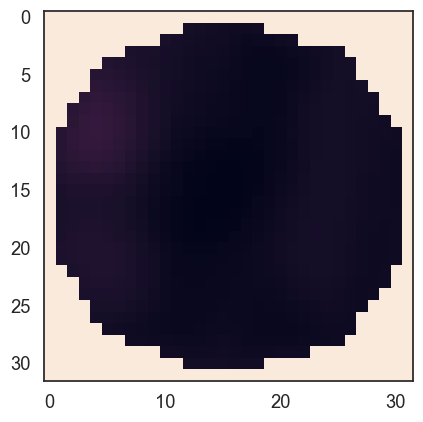

In [224]:
plt.imshow(image_test_normalized[:, :, 2]) # first participant, image of alpha band psd 
plt.show()